In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ThinFilmDataCreation as tfdc

In [2]:
import ThinFilmDataCreation as tfdc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.decomposition import NMF
import dask
import glob as glob
from tifffile import imread, imshow
import warnings
import dask

def attempt(Real_Data, Length, i, init= None, solver = 'cd', beta_loss = 'frobenius', iter = 500):
    NMF_model = NMF(n_components=i, init = init, solver = solver, beta_loss = beta_loss, max_iter = iter)
    NMF_data= NMF_model.fit_transform(Real_Data)
    fit_compos = NMF_model.components_
    Q = np.array(NMF_model.reconstruction_err_)*100
    warnings.filterwarnings("ignore", category=FutureWarning)
    return Q

def attempt2(Real_Data, Length, i, init= None, solver = 'cd', beta_loss = 'frobenius', iter = 500):
    NMF_model = NMF(n_components=i, init = init, solver = solver, beta_loss = beta_loss, max_iter = iter)
    NMF_data= NMF_model.fit_transform(Real_Data)
    fit_compos = NMF_model.components_
    Q = np.array(NMF_model.reconstruction_err_)*100
    warnings.filterwarnings("ignore", category=FutureWarning)
    return Q, fit_compos, NMF_data


def Run_NMF(Real_Data, init= None, solver = 'cd', beta_loss = 'frobenius', itear = 1000, show = False):
    
    """" Comparison of multiple components without manually comparing
    multiple components all at once. There are a few ways that this can be done. One way
    is to take the residuals of the datasets with themselves to see which is the closests to the 
    "correct" component. This may only be done on sample data potentially. Could include a 
    simulated dataset of what the standing component should look like give or take some 
    variations in the data. When the residuals are taken if it is less than some given 
    percentage the would be the dataset/NMF component to use further. There may be multiple
    thus having to go in manually to find differences. 
    
    To do this, will need to import the simulated XRD pattern from VESTA and then take the residual differences
    of each component and compared to the simulated pattern. Will have the program spit out the compnents that
    meet the cutoff. """

    In = init
    Solve = solver
    Beta = beta_loss
    It = itear
    

    jobs = [dask.delayed(attempt)(Real_Data, Real_Data.shape[1], i, In, Solve, Beta, It) for i in range(1, Real_Data.shape[1])]
    #jobs = [dask.delayed(attempt)(Real_Data, Real_Data.shape[1], i, In, Solve, Beta, It) for i in range(1,20)]
    calcs = dask.compute(jobs)[0]

    calcs = np.array(calcs)
    min_Q = np.min(calcs)
    noc = np.where(calcs == min_Q)
    noc_2 = noc[0]
    number_of_components = noc_2[0] +1

    Divergence, compos, NMF_Data_2 = attempt2(Real_Data, Real_Data.shape[1], number_of_components, In, Solve, Beta)
            
    
    print('The beta-divergence is: ', Divergence, '%\n','The final number of components used were',number_of_components+1, '\n') 
    
    
    m = pd.DataFrame(compos)
    m = m.T
    
    if show == True:
        plt.figure(figsize = (5,5))
        colors = plt.cm.magma(np.linspace(0,1, number_of_components))
        i = 0
        while i < number_of_components:
            plt.plot(m[i], c = colors[i], alpha = 0.7)
            i = i+1
    
    return m,NMF_Data_2, min_Q

def AggCluster(Number_Clusters, data):
    
    """A program that will take in the type of scikitlearn clustering algorithm
        desired and the number of clusters as well as the data in a numpy array
        and output the associated clusters with the original data. This will make
        the 'latent' space from the clustering algorithms have more meaning"""

    from sklearn.cluster import AgglomerativeClustering
    Make_Clusters= AgglomerativeClustering(n_clusters = Number_Clusters, compute_distances=True)
    y_kmeans = Make_Clusters.fit_predict(data)
    information = Make_Clusters.fit(data)
    parameter = information.distances_

    x = 0
    Understanding_data = {"Cluster_Number":[], "Int_Angle":[]};
    while x < len(data):
        Understanding_data["Cluster_Number"].append(y_kmeans[x])
        Understanding_data["Int_Angle"].append(data[x])
        x = x+1
        
    # Create an empty list to store the data
    data_list = []
    
        
    q = 0
    while q < Number_Clusters:
        z = 0
        plt.figure(figsize=(5,5))
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Agglomerative Clustering'+' ' +str(q))

        while z < len(data):
            if Understanding_data["Cluster_Number"][z] == q:
                plt.plot(Understanding_data["Int_Angle"][z], label = 'Component'+str(z))
            z = z+1
    
        # Check if the plot looks good if the plot looks good, append the data to the list
        plt.show(block = False)
        plt.pause(0.1)
        
        if input("Do the identified components look like an isotropic scattering signal? (y/n)") == 'y':
            i = 0
            while i < len(data):
                if Understanding_data["Cluster_Number"][i] == q:
                    data_list.append(Understanding_data["Int_Angle"][i])
                i = i+1
                
        q = q+1
    
    return Understanding_data, data_list


def smooth_components(Identified_components, filter_strength = 2, show = False):
    '''A function that will smooth the components identified from the agglomerative clustering algorithm'''
    
    # Importing required library
    from scipy.signal import savgol_filter
    
    # Defining a dictionary that maps filter strength to the number of points for the smoothing window
    strength_to_points = {1: 3, 2: 5, 3: 7, 4: 11, 5: 15}
    
    # Retrieving the number of points for the smoothing window based on the filter strength provided
    points = strength_to_points.get(filter_strength)

    # Applying Savitzky-Golay filter to smooth the identified components by taking their average along the columns
    smoothed_compos = savgol_filter(np.mean(Identified_components, axis = 0), points, 1)
    
    # If show argument is True, plotting the original components, their average, and the smoothed components
    if show == True:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
        ax1.plot(Identified_components.T, c = 'k', linewidth = 2, alpha = 0.7)
        ax1.set_title('Identified Components')
        ax1.set_ylabel('Intensity')
        ax2.plot(np.mean(Identified_components, axis = 0), c = 'r', linewidth = 2, alpha = 0.7)
        ax2.set_ylabel('Intensity')
        ax2.set_title('Mean of Identified Components')
        ax3.plot(smoothed_compos, c = 'g', linewidth = 2, alpha = 0.7, label = 'Smoothed Component')
        ax3.scatter(np.arange(len(np.mean(Identified_components, axis = 0))), np.mean(Identified_components, axis = 0), c = 'r', s = 10, 
                    label = 'Mean Component')
        ax3.set_xlabel('Data Points')
        ax3.set_title('Smoothed Component')
        ax3.set_ylabel('Intensity')
        ax3.legend()
    
    # Returning the smoothed components
    return smoothed_compos

def run_nmfac(Data, initialize_iter = 0, clusters = 5):
    """A function that will run the NMF algorithm and then cluster with agglomerative clustering the components and returns the 
        identified components for later PDF analysis. The function starts with a random initializer
        that will be used to initialize the NMF algorithm. The user can decide how many iterations the 
        initializer takes. Then it will go through the NMF algorithm and compare the beta divergences of all the
        initializations and select the one with the lowest. By default, there is no initializer and the NMF algorithm
        uses preset parameters to run the algorithm. """
        
        #NMF Parameter Values
        
    import warnings
    warnings.filterwarnings("ignore")
    
    
    init_params = ['random', 'nndsvd', 'nndsvda', 'nndsvdar']
    solver_params = ['cd', 'mu']
    beta_loss_params = ['frobenius', 'kullback-leibler']
    tol_params = np.arange(0.00001, 0.01, 0.0001)
    max_iter_params = np.arange(100, 10000, 100)
    shuffle_params = [True, False]
        
    #When random initializers are not wanted
    if initialize_iter == 0:
        weights, components, beta = Run_NMF(Data, show = True)
        AggComponents = np.array(components).T
        AggClusters, found_compos = AggCluster(clusters, AggComponents)
        
        found_compos = np.array(found_compos)
        
    elif initialize_iter > 0:
        beta_div = []
        
        init_for_init = np.random.choice(init_params,initialize_iter)
        solver_for_init = np.random.choice(solver_params, initialize_iter)
        beta_loss_for_init = np.random.choice(beta_loss_params, initialize_iter)
        tol_for_init = np.random.choice(tol_params, initialize_iter)
        max_iter_for_init = np.random.choice(max_iter_params, initialize_iter)
        shuffle_for_init = np.random.choice(shuffle_params, initialize_iter)
        
        for i in range(initialize_iter):
            
            if beta_loss_for_init[i] == 'kullback-leibler':
                solver_for_init[i] = 'mu'
                
            print('The parameters selected for run' + str([i]) + ' are ' + str(init_for_init[i]) + ', ' + str(solver_for_init[i]) + ', ' + str(beta_loss_for_init[i]) + ', ' + str(tol_for_init[i]) + ', ' + str(max_iter_for_init[i]) + ', ' + str(shuffle_for_init[i]) + '. \n' )
            weights, components, beta = Run_NMF(Data, init = init_for_init[i], solver = solver_for_init[i], 
                                                beta_loss = beta_loss_for_init[i], itear = max_iter_for_init[i], show = False)
            
            beta_div.append(beta)
        beta_np = np.array(beta_div)
        good_init = np.argmin(beta_np)
        
        weights, components, beta = Run_NMF(Data, show = True, init = init_for_init[good_init], solver = solver_for_init[good_init], beta_loss=beta_loss_for_init[good_init],
                                             itear = max_iter_for_init[good_init])
        
        AggComponents = np.array(components).T
        AggClusters, found_compos = AggCluster(clusters, AggComponents)
        
        found_compos = np.array(found_compos)
            
        
    return found_compos

In [4]:
from PIL import Image
import pyFAI, fabio
from pyFAI.gui import jupyter
import pyFAI
import os
import matplotlib.pyplot as plt
os.chdir(r'C:\Users\dalverson\Dropbox (UFL)\DAlversonShare\Coding\Sorting Single Crystal Background\CNN_for_Image_Denoising')

#Tiff file you want to be integrated
match_result = fabio.open("match_result.tiff").data


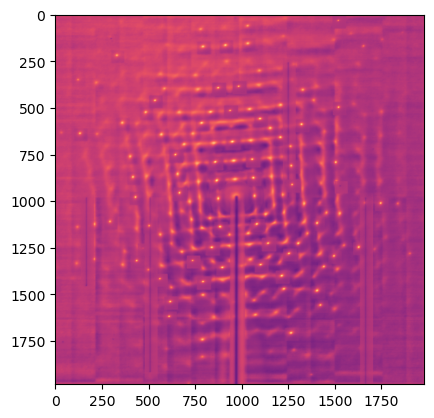

In [13]:
plt.figure()
plt.imshow(match_result, cmap= 'magma', vmin = -1, vmax = 1)

In [16]:
data_to_use = np.clip(match_result, 0, None)

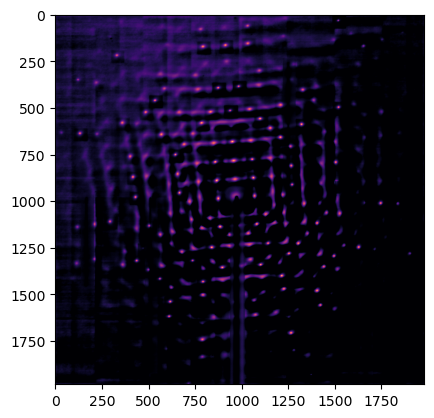

In [18]:
plt.imshow(data_to_use, cmap= 'magma', vmin = 0, vmax = 1)

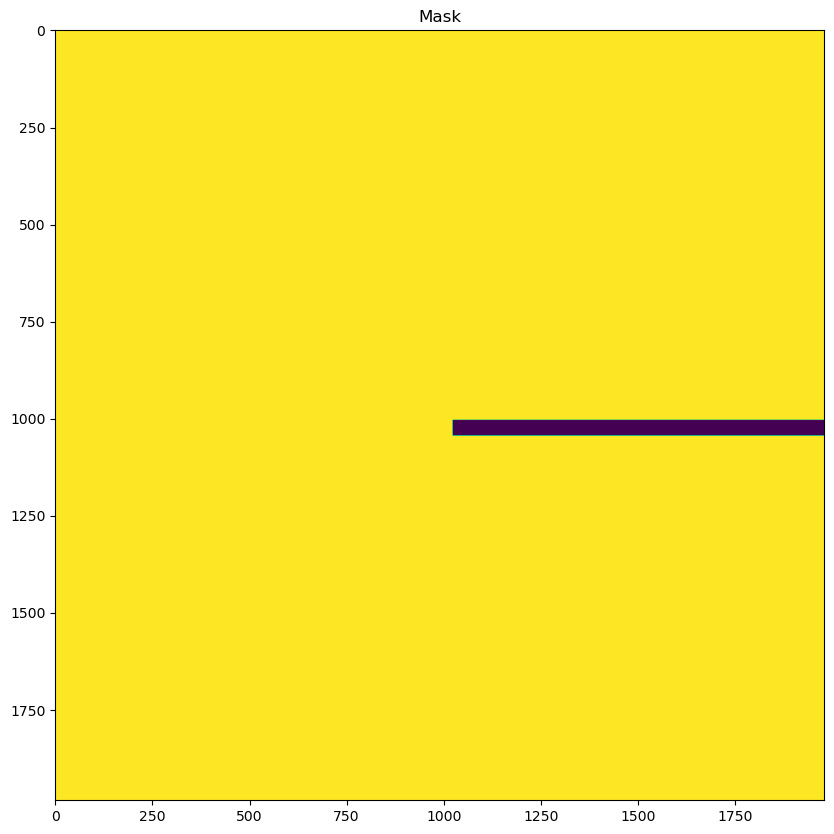

In [20]:
import ThinFilmDataCreation as tfdc

mask = tfdc.create_mask(data_to_use, 20)

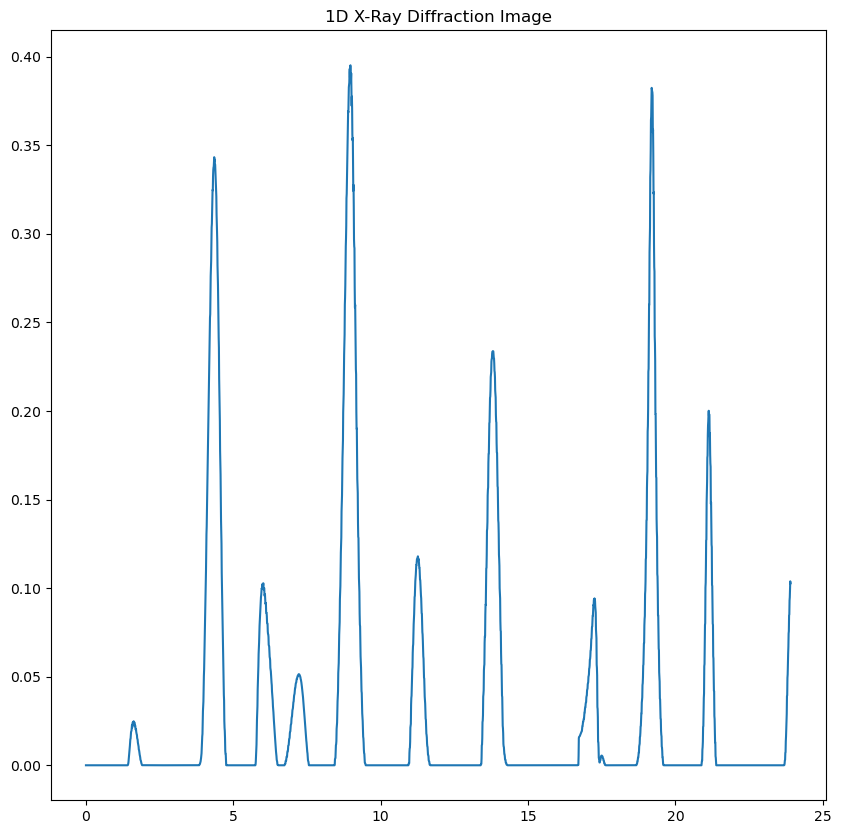

In [21]:
q, line_data = tfdc.integrate_image(data_to_use, .254, .1667e-10, mask = mask, show = True)

c:\Users\dalverson\Anaconda3\envs\dask_working\lib\site-packages\ThinFilmDataCreation\ThinFilmDataCreation.py:287: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i] = I
c:\Users\dalverson\Anaconda3\envs\dask_working\lib\site-packages\ThinFilmDataCreation\ThinFilmDataCreation.py:287: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i] = I
c:\Users\dalverson\Anaconda3\envs\dask_working\lib\site-packages\ThinFilmDataCreation\ThinFilmDataCreation.py:287: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resu

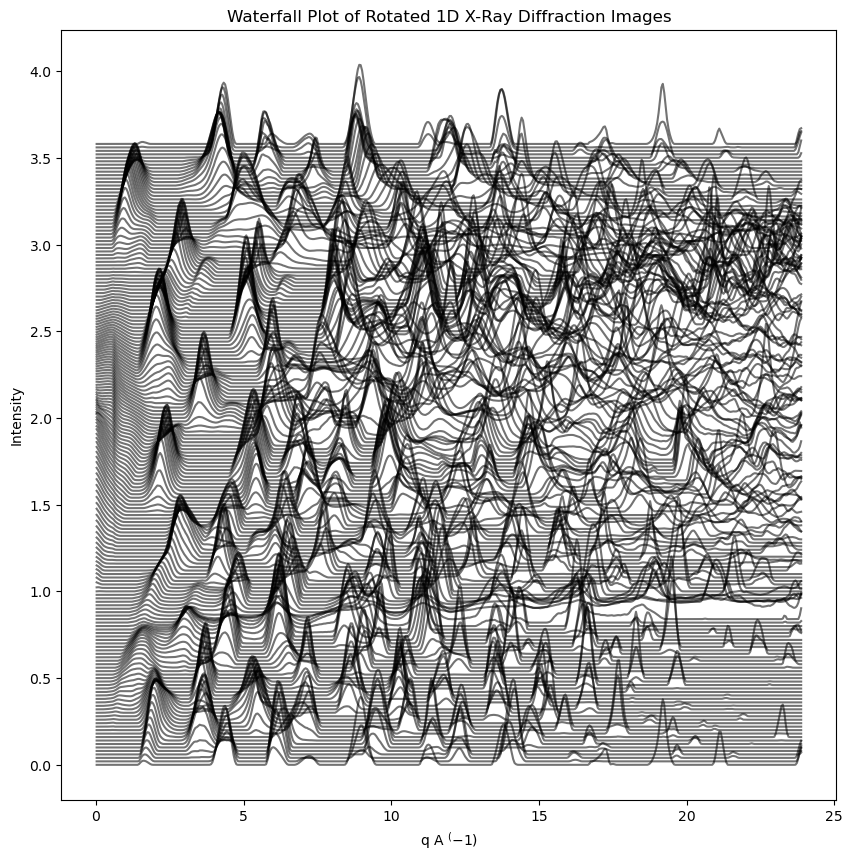

In [22]:
q_rot_int, rot_data = tfdc.rotate_and_integrate(data_to_use, 2, .254, .1667e-10, resolution = 500, mask = mask)

The beta-divergence is:  103.84306743442271 %
 The final number of components used were 177 



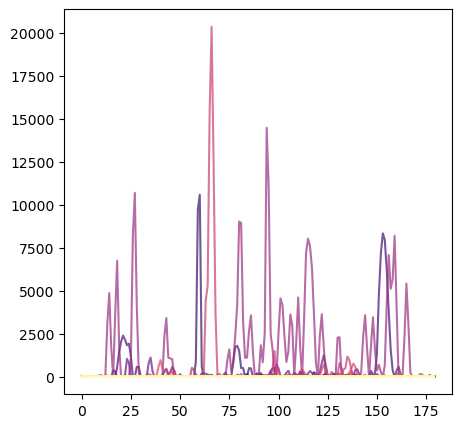

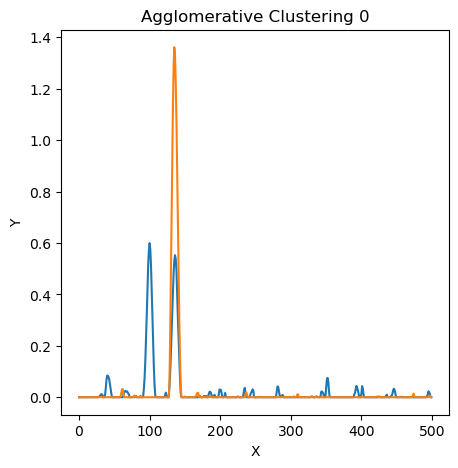

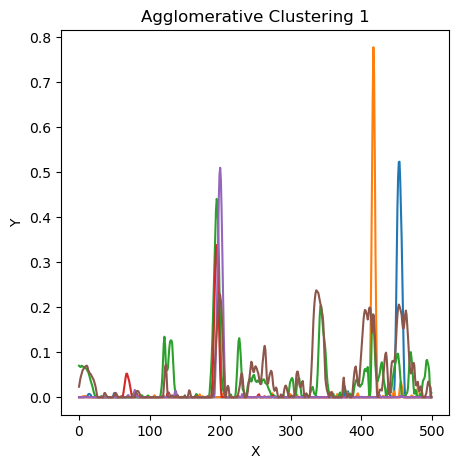

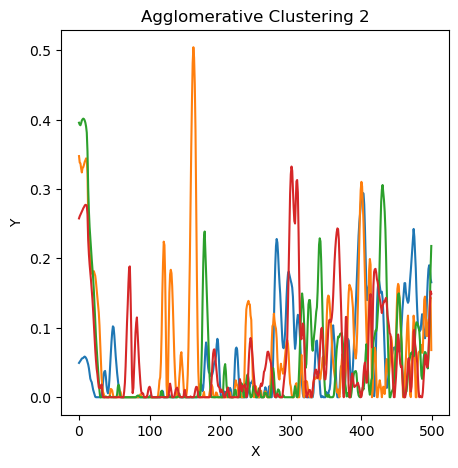

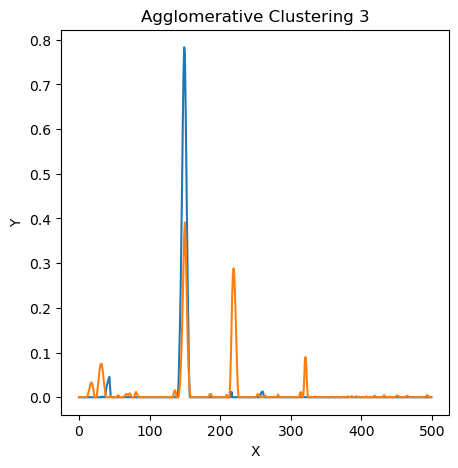

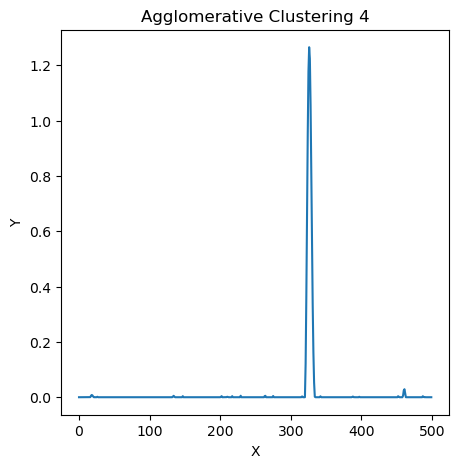

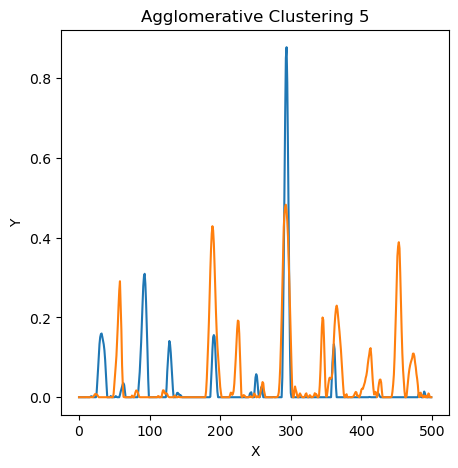

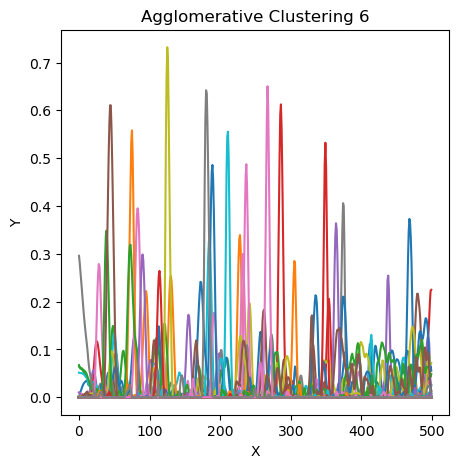

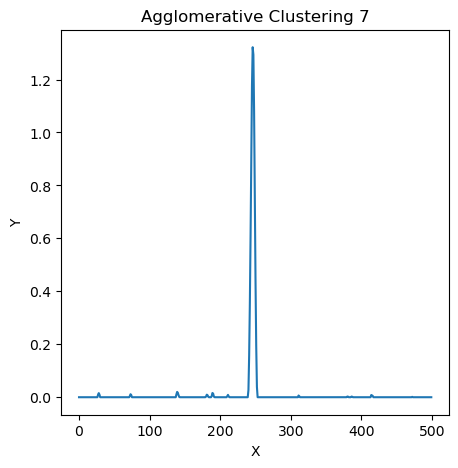

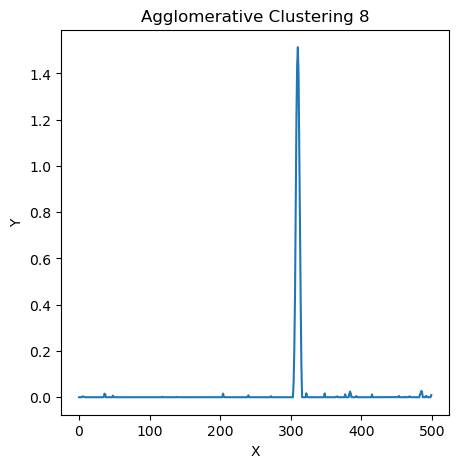

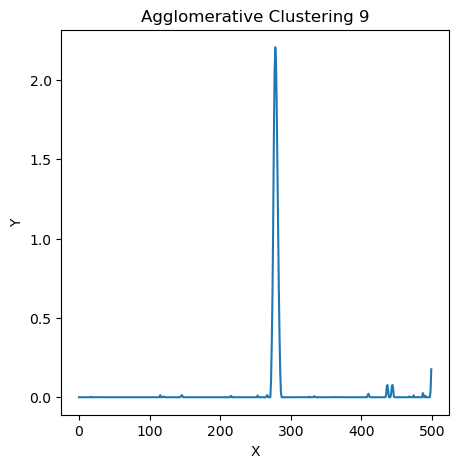

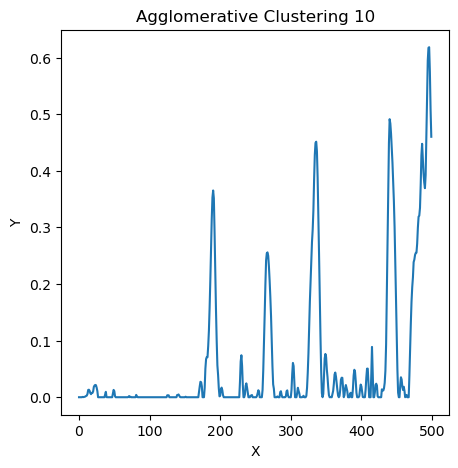

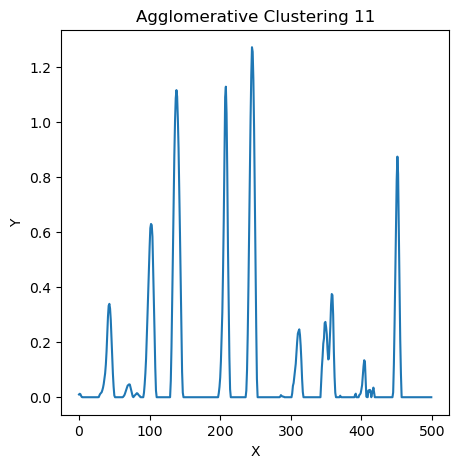

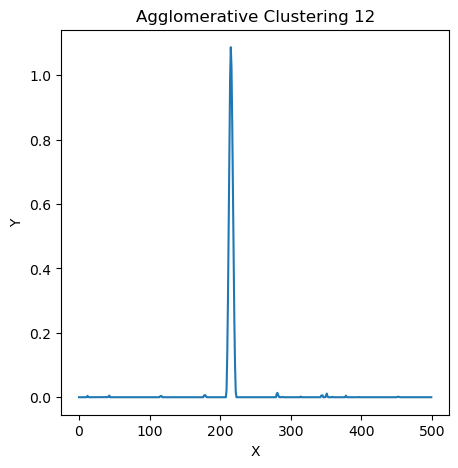

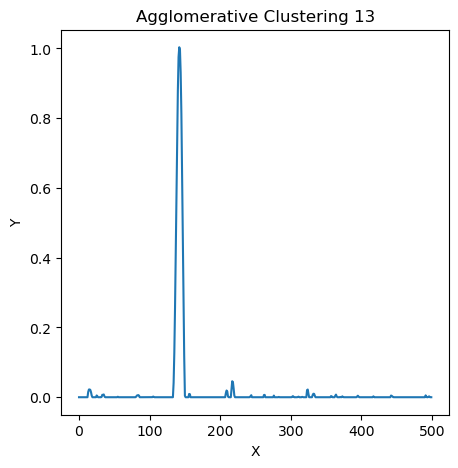

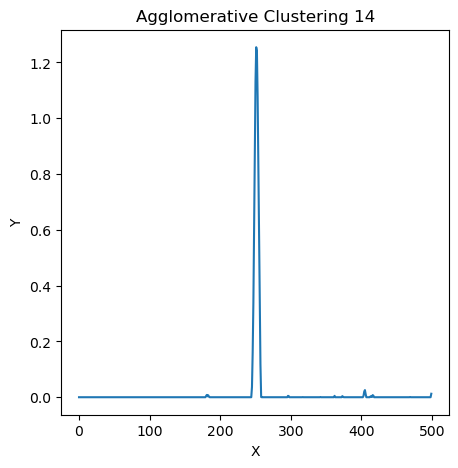

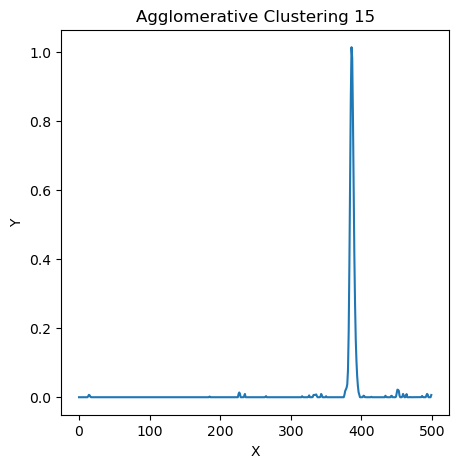

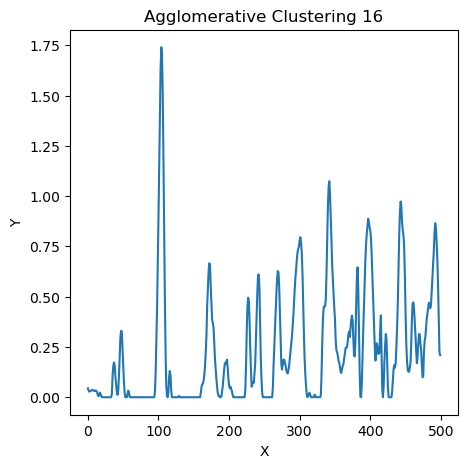

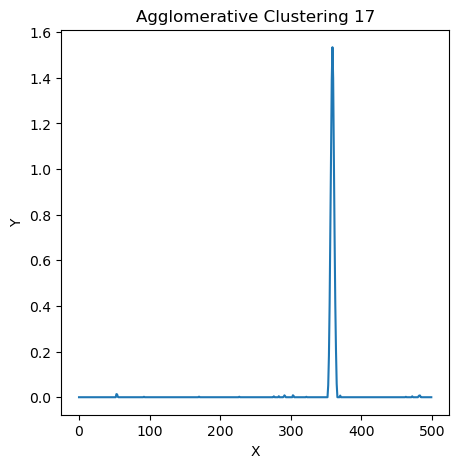

In [23]:
my_comps = run_nmfac(rot_data, clusters = 18)

In [28]:
os.chdir(r'C:\Users\dalverson\Dropbox (UFL)\DAlversonShare\Coding\Sorting Single Crystal Background\CNN_for_Image_Denoising')
mask2 = fabio.open("match_result.tiff").data

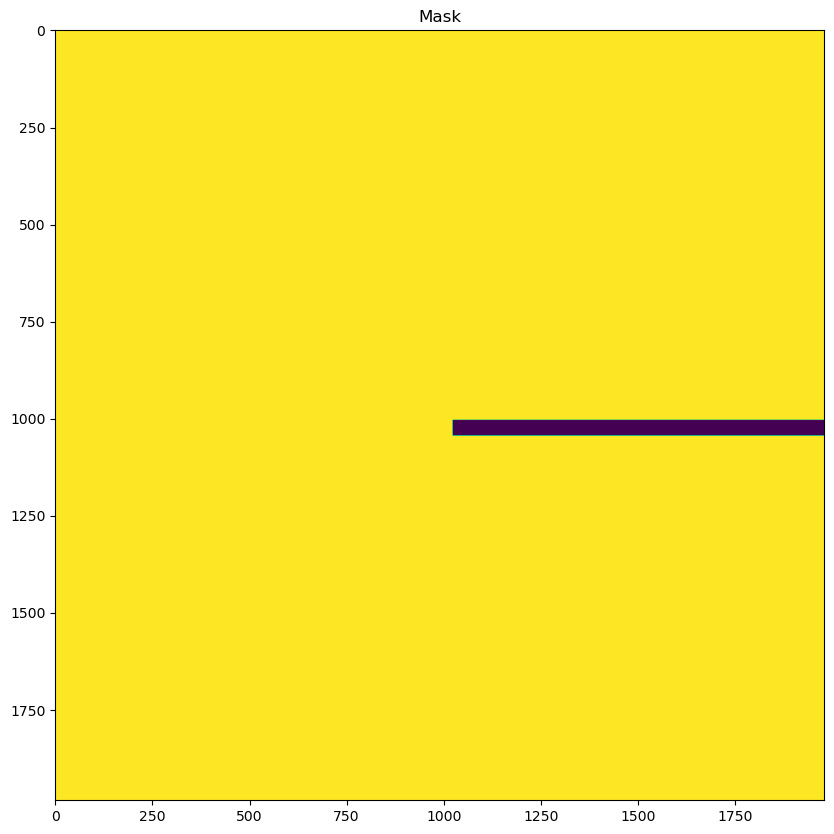

In [32]:
mask = tfdc.create_mask(match_result, 20)

In [49]:
from scipy.ndimage import zoom

# Assuming your original image is stored in the 'image' numpy array

# Determine the desired size
desired_size = (2048, 2048)

# Calculate the scaling factors for each dimension
scale_factors = (desired_size[0] / mask.shape[0], desired_size[1] / mask.shape[1])

# Perform the zoom operation to resize the image
resized_image = zoom(mask, scale_factors)

resized_image = np.clip(resized_image, 0, 1)


In [50]:
resized_image = np.logical_not(resized_image).astype(int)

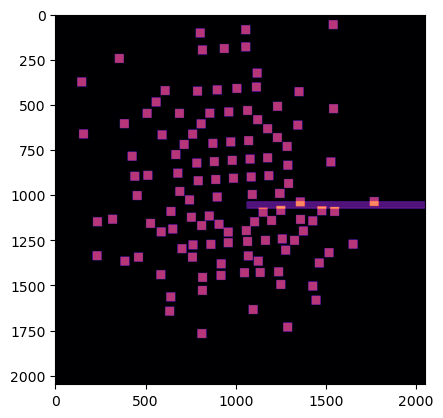

In [51]:
new_mask = resized_image + mask2
plt.imshow(new_mask, cmap = 'magma')

In [52]:
new_mask = np.clip(new_mask, 0, 1)

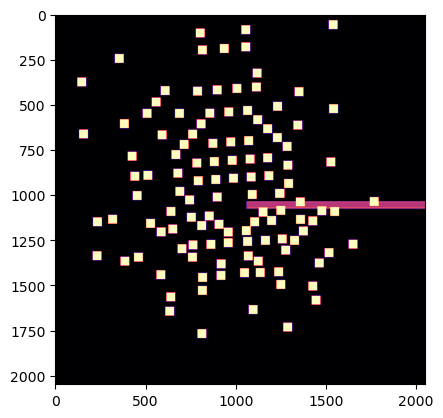

In [53]:
plt.imshow(new_mask, cmap = 'magma')

In [61]:
new_mask.min()

0.0

In [54]:
os.chdir(r'D:\DAlversonShare\Fellowship Application Materials\Phase Change Materials Project\GST_Data_Sum2021\tiff_base\0C_HT02_SC\dark_sub')

#Tiff file you want to be integrated
sc_img = fabio.open("Xtalline_GST_SC_avg_im.tiff").data

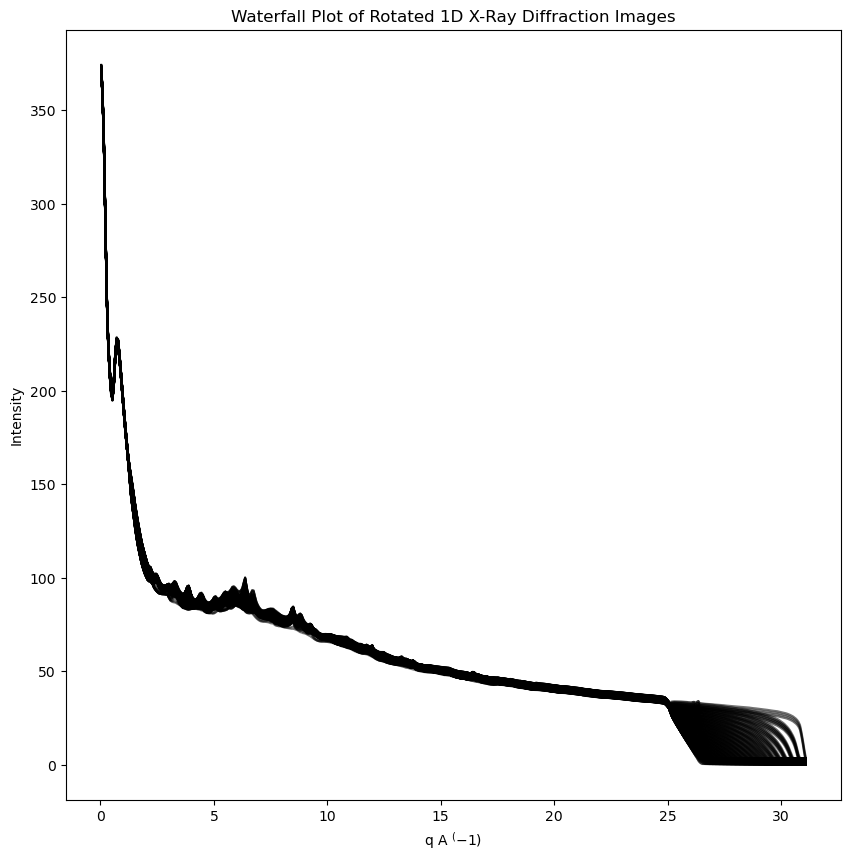

In [63]:
q_rot_int_real, sc_im_data = tfdc.rotate_and_integrate(sc_img, 2, .254, .1667e-10, resolution = 500, mask = new_mask)

The beta-divergence is:  34166.497204864296 %
 The final number of components used were 9 



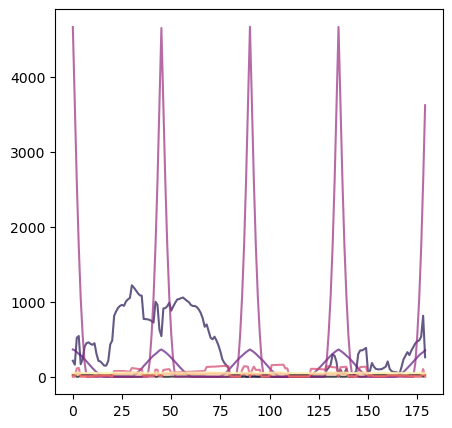

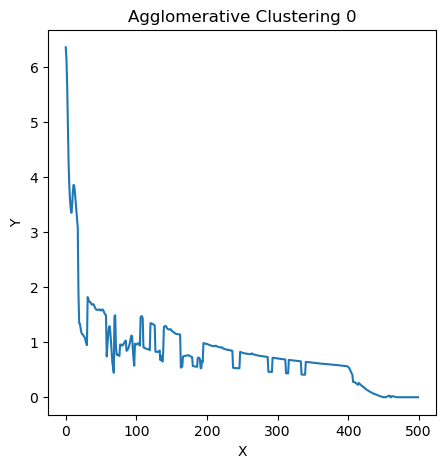

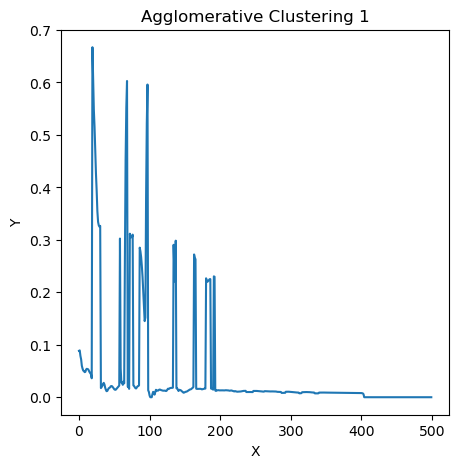

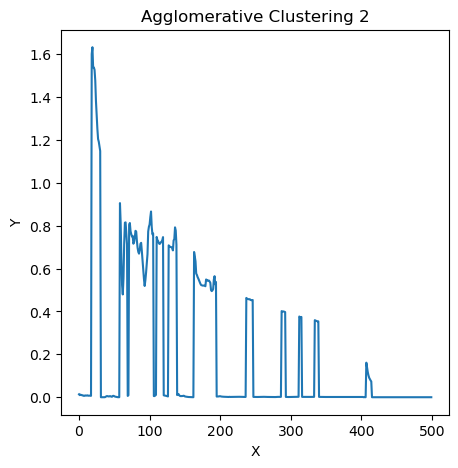

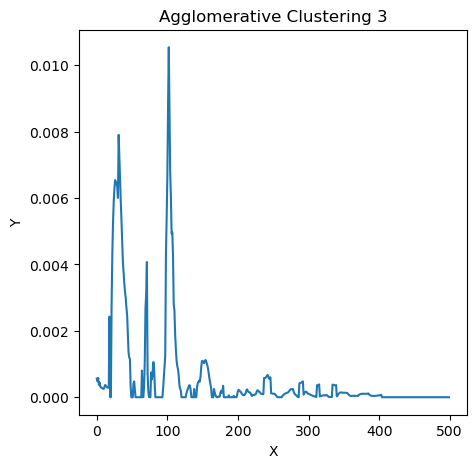

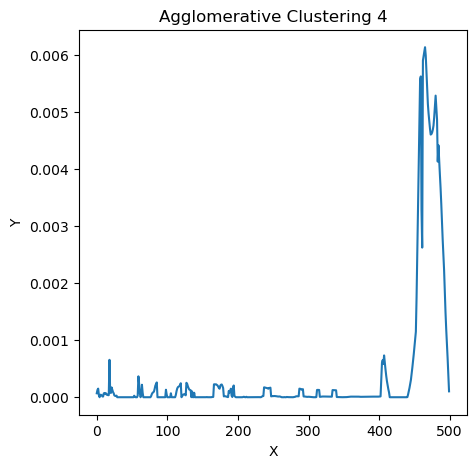

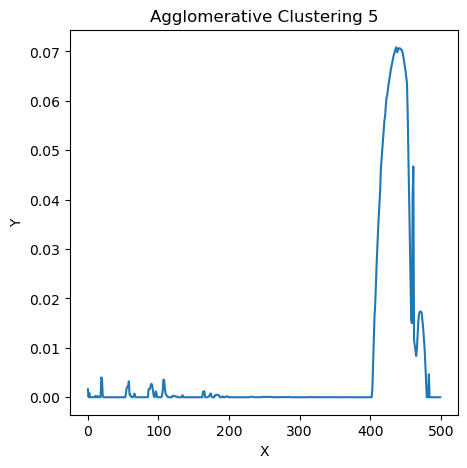

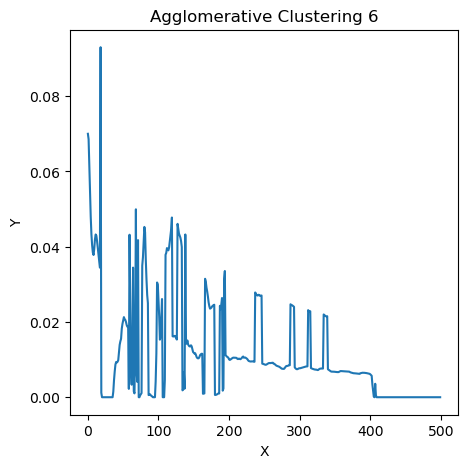

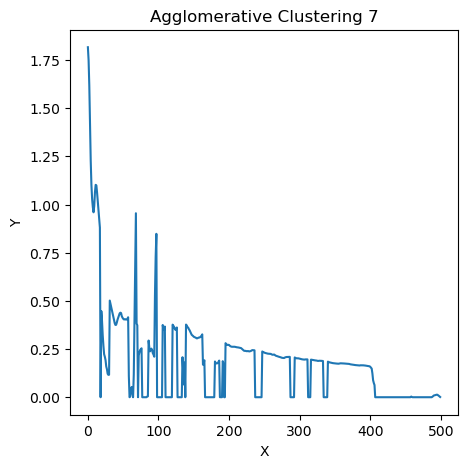

In [69]:
my_comps = run_nmfac(sc_im_data, clusters = 8)

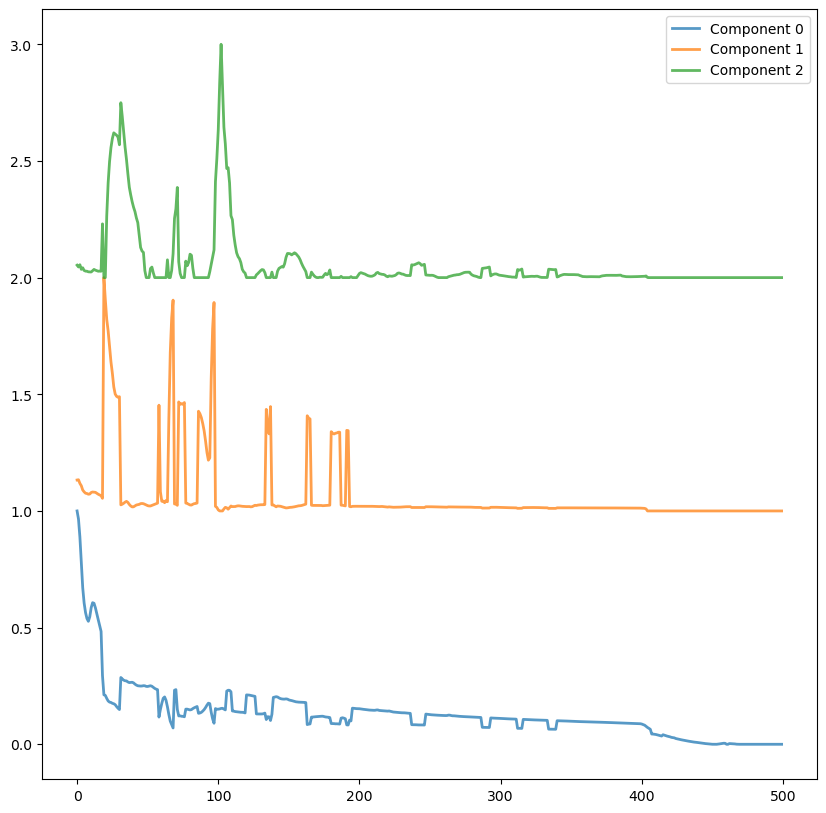

In [70]:
plt.figure(figsize = (10, 10))

normalized_comps = []

def normalize_components(components):
    for i in range(len(components)):
        normalized_comps.append(components[i]/np.max(components[i]))
    return normalized_comps

normalized_comps = normalize_components(my_comps)

for i in range(len(normalized_comps)):
    plt.plot(normalized_comps[i] + i, linewidth = 2, alpha = 0.75, label = 'Component ' + str(i))

plt.legend()

In [71]:
new_comps = np.array([normalized_comps[1], normalized_comps[0]])

added_comps_v2 = np.sum(new_comps, axis = 0)

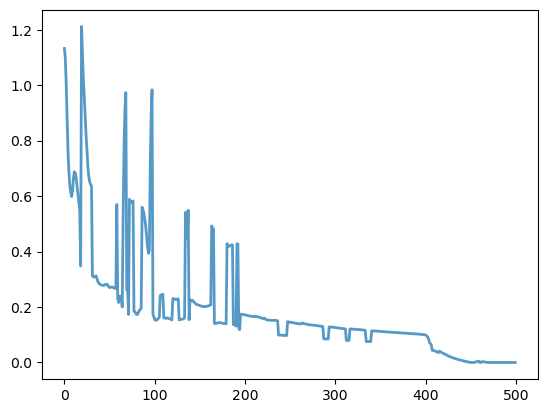

In [72]:
plt.plot(added_comps_v2, linewidth = 2, alpha = 0.75, label = 'Component ' + str(i))

In [73]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import csv
import glob as glob
from tifffile import imread, imshow

def read_index_data_smart(filename,
                          junk=None, backjunk=None,
                          splitchar=None, do_not_float=False, 
                          shh=True, use_idex=[0,1]):
    
    """ A general 2-column data reader that attempts to 'smartly' skip metadata.
    The to-be-skipped metadata can be specified as 'junk' and 'backjunk', corresponding
    to the number of beginning and ending lines to skip. 
    'splitchar' specifies the character used to seperate columns.
    do_not_float is a bool (default False) to keep data as strings instead of convert to float.
    shh is a bool (default True) to supress certain debugging print statements.
    use_idex (a list) specifies which columns to return (default 0th and 1st). """
    
    with open(filename,'r') as infile:
        datain = infile.readlines()
    
    if junk == None:
        for i in range(len(datain)):
            try:
                for j in range(10):
                    x1,y1 = float(datain[i+j].split(splitchar)[use_idex[0]]), float(datain[i+j].split(splitchar)[use_idex[1]])
                junk = i
                break
            except:
                pass 
                
    if backjunk == None:
        for i in range(len(datain),-1,-1):
            try:
                x1,y1 = float(datain[i].split(splitchar)[use_idex[0]]), float(datain[i].split(splitchar)[use_idex[1]])
                backjunk = len(datain)-i-1
                break
            except:
                pass

    if backjunk == 0:
        datain = datain[junk:]
    else:
        datain = datain[junk:-backjunk]
    
    xin = np.zeros(len(datain))
    yin = np.zeros(len(datain))
    
    if do_not_float:
        xin = []
        yin = []
    
    if shh == False:
        print ('length '+str(len(xin)))
    if do_not_float:
        if splitchar==None:
            for i in range(len(datain)):
                xin.append(datain[i].split()[use_idex[0]])
                yin.append(datain[i].split()[use_idex[1]])
        else:
            for i in range(len(datain)):
                xin.append(datain[i].split(splitchar)[use_idex[0]])
                yin.append(datain[i].split(splitchar)[use_idex[1]])    
    else:        
        if splitchar==None:
            for i in range(len(datain)):
                xin[i]= float(datain[i].split()[use_idex[0]])
                yin[i]= float(datain[i].split()[use_idex[1]])
        else:
            for i in range(len(datain)):
                xin[i]= float(datain[i].split(splitchar)[use_idex[0]])
                yin[i]= float(datain[i].split(splitchar)[use_idex[1]])   
        
    return xin,yin    

def write_out_file(filename,x,y):
    """ write out a two-column dataset (x,y) with file named 'filename'"""
    outf = open(filename,'w')
    for i in range(len(x)):
        outf.write(str(x[i])+' '+str(y[i])+'\n')
    outf.close()

def read_all_into_list(file_list):
    #read the first file
    x,y = read_index_data_smart(file_list[0])
    my_df = pd.DataFrame(index=x)
    my_df[0] = y
    for i in range(1,len(file_list)):
        x,y = read_index_data_smart(file_list[i])
        my_df[i] = y
    return my_df

In [74]:
os.chdir(r'C:\Users\dalverson\Dropbox (UFL)\DAlversonShare\Coding\Sorting Single Crystal Background\Experiments-PCAvsNMF\Working_Codes\Real_Single_Crystal_Integration')
file_list = sorted(glob.glob('Thin_Film_Signal_from_FS.xy'))
real_ish = read_all_into_list(file_list)

real_ish_pd = pd.DataFrame(real_ish)

q_for_real = real_ish_pd.index

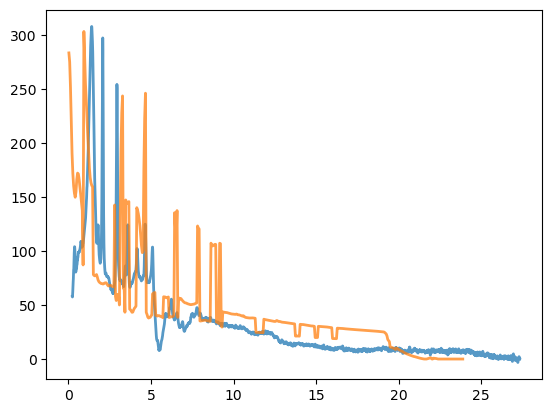

In [79]:
plt.figure()
plt.plot(q_for_real, real_ish_pd[0], linewidth = 2, alpha = 0.75, label = 'Component ' + str(0))
plt.plot(q_rot_int, added_comps_v2*250, linewidth = 2, alpha = 0.75, label = 'Component ' + str(1))